In [2]:
import numpy as np
import torch
import pandas as pd
import json, csv, random
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import logging
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s - %(message)s', datefmt = '%m/%d/%Y %H:%M:%S', level = logging.INFO)
logger = logging.getLogger(__name__)

# Ideas

## Normalizing Embeddings before passing to loss function and doing computations

In [5]:
import numpy as np
import pickle

idx = 0

print(f'====== SupCon method ======')
outputs_supcon = pickle.load(open('results/4M-supervised-contrastive-SGD-cosine-submodalities-text-first-gold-no_neg_sampling-1024/seed-24/outputs.pkl', 'rb'))
print(f"norm of speech: {np.linalg.norm(outputs_supcon['test']['audio'][idx])}, norm of text: {np.linalg.norm(outputs_supcon['test']['language'][idx])}, norm of rgb: {np.linalg.norm(outputs_supcon['test']['rgb'][idx])}, norm of depth: {np.linalg.norm(outputs_supcon['test']['depth'][idx])}")


outputs_simple_mma = pickle.load(open('results/4M-mma-simple-SGD-cosine-submodalities-text-anchor-gold-no_neg_sampling-1024/seed-24/outputs.pkl', 'rb'))
print(f'====== Simple MMA method ======')
print(f"norm of speech: {np.linalg.norm(outputs_simple_mma['test']['audio'][idx])}, norm of text: {np.linalg.norm(outputs_simple_mma['test']['language'][idx])}, norm of rgb: {np.linalg.norm(outputs_simple_mma['test']['rgb'][idx])}, norm of depth: {np.linalg.norm(outputs_simple_mma['test']['depth'][idx])}")



outputs_emma = pickle.load(open('results/4M-eMMA-cosine-submodalities-text-anchor-gold-no_neg_sampling-1024/seed-24/outputs.pkl', 'rb'))
print(f'====== eMMA method ======')
print(f"norm of speech: {np.linalg.norm(outputs_emma['test']['audio'][idx])}, norm of text: {np.linalg.norm(outputs_emma['test']['language'][idx])}, norm of rgb: {np.linalg.norm(outputs_emma['test']['rgb'][idx])}, norm of depth: {np.linalg.norm(outputs_emma['test']['depth'][idx])}")

====== SupCon method ======
norm of speech: 1.4311357736587524, norm of text: 1.5242607593536377, norm of rgb: 1.447983741760254, norm of depth: 1.5198653936386108
====== Simple MMA method ======
norm of speech: 0.11098293960094452, norm of text: 0.6008701324462891, norm of rgb: 0.1465524137020111, norm of depth: 0.17395949363708496
====== eMMA method ======
norm of speech: 0.1356561928987503, norm of text: 0.3704216778278351, norm of rgb: 0.13695642352104187, norm of depth: 0.15109695494174957


## Contrastive Loss

In [9]:
anchor = torch.rand((64, 1024))
positive = torch.rand((64, 1024))
negative = torch.rand((64, 1024))
anchor_dot_contrast = torch.matmul(anchor, positive.T)
print('anchor_dot_contrast',anchor_dot_contrast.shape)
logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
print('logits_max',logits_max.shape)
logits = anchor_dot_contrast - logits_max.detach()
print('logits',logits.shape)
res = torch.diagonal(anchor_dot_contrast)
res.shape

anchor_dot_contrast torch.Size([64, 64])
logits_max torch.Size([64, 1])
logits torch.Size([64, 64])


torch.Size([64])

## Supervised Contrastive Loss

In [50]:
from torchvision import datasets, transforms

bsz = 4

class TwoCropTransform:
    """Create two crops of the same image"""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
normalize = transforms.Normalize(mean=mean, std=std)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    normalize,
])

train_dataset = datasets.CIFAR10(root='../tutorial/', transform=TwoCropTransform(train_transform), download=True)
train_sampler = None
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bsz, shuffle=(train_sampler is None), num_workers=16, pin_memory=True, sampler=train_sampler)



Files already downloaded and verified


In [58]:
import torch.nn as nn
import torch.nn.functional as F



class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(BasicBlock, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1, is_last=False):
        super(Bottleneck, self).__init__()
        self.is_last = is_last
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        preact = out
        out = F.relu(out)
        if self.is_last:
            return out, preact
        else:
            return out




class ResNet(nn.Module):
    def __init__(self, block, num_blocks, in_channel=3, zero_init_residual=False):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves
        # like an identity. This improves the model by 0.2~0.3% according to:
        # https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for i in range(num_blocks):
            stride = strides[i]
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x, layer=100):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        return out


def resnet18(**kwargs):
    return ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)

model_dict = {'resnet18': [resnet18, 512],}

class SupConResNet(nn.Module):
    """backbone + projection head"""
    def __init__(self, name='resnet18', head='mlp', feat_dim=128):

        super(SupConResNet, self).__init__()
        model_fun, dim_in = model_dict[name]
        self.encoder = model_fun()
        if head == 'linear':
            self.head = nn.Linear(dim_in, feat_dim)
        elif head == 'mlp':
            self.head = nn.Sequential(
                nn.Linear(dim_in, dim_in),
                nn.ReLU(inplace=True),
                nn.Linear(dim_in, feat_dim)
            )
        else:
            raise NotImplementedError(
                'head not supported: {}'.format(head))


    def forward(self, x):
        feat = self.encoder(x)
        feat = F.normalize(self.head(feat), dim=1)
        return feat

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor


def visualize(img):
    unorm = UnNormalize(mean = (0.4914, 0.4822, 0.4465), std = (0.2023, 0.1994, 0.2010))
    fig = plt.figure()
    img = unorm(img).numpy().transpose(1,2,0)
    plt.imshow(img)


model = SupConResNet()
for idx, (images, labels) in enumerate(train_loader):
    # print(labels.shape, labels)
    labels = labels.contiguous().view(-1, 1)
    # print(labels.shape , labels)
    mask = torch.eq(labels, labels.T).float()
    print(f'mask: {mask}')
    print(len(images))
    print(images[0].shape)
    # visualize(images[0][0])
    # visualize(images[1][0])
    # visualize(images[0][1])
    # visualize(images[1][1])
    images = torch.cat([images[0], images[1]], dim=0)
    print(f'images shape: {images.shape}')
    bsz = labels.shape[0]
    features = model(images)
    print(f'features before: {features.shape}')
    f1, f2 = torch.split(features, [bsz, bsz], dim=0)
    print(f'f1 shape: {f1.shape}, f2 shape: {f2.shape}')
    features = torch.cat([f1.unsqueeze(1), f2.unsqueeze(1)], dim=1)
    print(f'features after: {features.shape}')

    contrast_count = features.shape[1]
    print(f'contrast_count: {contrast_count}')
    anchor_count = contrast_count
    contrast_feature = torch.unbind(features, dim=1)
    print(f'contrast_feature:{len(contrast_feature)}')
    contrast_feature = torch.cat(contrast_feature, dim=0)
    print(f'contrast_feature:{contrast_feature.shape}')
    
    anchor_feature = contrast_feature

    mask = mask.repeat(anchor_count, contrast_count)
    print(f'mask: {mask}')
    # mask-out self-contrast cases
    logits_mask = torch.scatter(
        torch.ones_like(mask),
        1,
        torch.arange(bsz * anchor_count).view(-1, 1),
        0
    )
    print(f'logits_mask\n: {logits_mask}')
    mask = mask * logits_mask
    print(f'mask:\n {mask}')

    # compute logits
    anchor_dot_contrast = torch.div(
        torch.matmul(anchor_feature, contrast_feature.T), 0.07)
    # for numerical stability
    logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
    logits = anchor_dot_contrast - logits_max.detach()
    print(f'logits:\n {logits}')
    # compute log_prob
    exp_logits = torch.exp(logits) * logits_mask
    print(f'exp_logits:\n {exp_logits}')
    
    log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
    print(f'torch.log(exp_logits.sum(1, keepdim=True)): {torch.log(exp_logits.sum(1, keepdim=True))}')
    print(f'log prob:\n {log_prob}')

    print(f'mask * log_prob:\n {mask * log_prob}')
    # compute mean of log-likelihood over positive
    mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
    print(f'mean_log_prob_pos:\n {mean_log_prob_pos}')
    
    mean_log_prob_pos = mean_log_prob_pos.view(anchor_count, bsz)
    print(f'mean log prob pos view:\n {mean_log_prob_pos}')

    break

mask: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 1.]])
2
torch.Size([4, 3, 32, 32])
images shape: torch.Size([8, 3, 32, 32])
features before: torch.Size([8, 128])
f1 shape: torch.Size([4, 128]), f2 shape: torch.Size([4, 128])
features after: torch.Size([4, 2, 128])
contrast_count: 2
contrast_feature:2
contrast_feature:torch.Size([8, 128])
mask: tensor([[1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0., 1., 0., 1.],
        [1., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0., 1., 0., 1.]])
logits_mask
: tensor([[0., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 1., 1., 1.],
        [1., 1., 0., 1., 1., 1., 1., 1.],
        [1., 1., 1., 0., 1., 1., 1., 1.],
        [1., 1., 1., 1., 0., 1., 1., 1.],
        [1., 1., 1., 1., 1., 0., 1.,

In [34]:
from sklearn import preprocessing
labels = ['apple', 'potato', 'apple',  'kiwi', 'pen', 'laptop', 'pen', 'potato']
le = preprocessing.LabelEncoder()
targets = le.fit_transform(labels)
print(targets)
targets = torch.as_tensor(targets)
print(f'targets: {type(targets)}, {targets.shape}')
targets = targets.contiguous().view(-1, 1)
mask = torch.eq(targets, targets.T).float()
print(mask)

[0 4 0 1 3 2 3 4]
targets: <class 'torch.Tensor'>, torch.Size([8])
targets: <class 'torch.Tensor'>, torch.Size([8])
tensor([[1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1.]])


## Loss Function on Toy dataset

In [166]:
# The other method for creating the dataset
a = {'modality 0':[], 'modality 1':[], 'modality 2':[], 'labels': []}
for i in range(num_class):
    low = 5*i
    high = 5+i*5
    for mod in range(num_modal):
        a['modality '+str(mod)].append(np.random.randint(low,high, size=(3)) )
    a['labels'].append(i)
logger.debug(a)

{'modality 0': [array([2, 4, 4]), array([5, 5, 5]), array([11, 12, 12]), array([18, 19, 19])], 'modality 1': [array([1, 4, 4]), array([7, 7, 6]), array([11, 13, 14]), array([18, 17, 18])], 'modality 2': [array([0, 4, 4]), array([6, 7, 7]), array([11, 13, 10]), array([17, 16, 16])], 'labels': [0, 1, 2, 3]}


In [3]:
def dataset_chaotic_uniform(num_class, num_modal, num_samples):
    dataset_chaotic = {'features': [], 'labels':[], 'labels-per-obj': [], 'modality': []}
    low = 0
    high = 20
    for i in range(num_class):
        print(low, high)
        dataset_chaotic['features'].extend(np.random.randint(low,high, size=(int(num_samples/num_class), 3)) )
        dataset_chaotic['labels'].extend(int(num_samples/num_class)*[i])
        dataset_chaotic['labels-per-obj'].append(i)
        dataset_chaotic['modality'].extend([0,1,2])
        
    dataset_chaotic['features'] = np.array(dataset_chaotic['features'])
    dataset_chaotic['labels'] = np.array(dataset_chaotic['labels'])
    dataset_chaotic['modality'] = np.array(dataset_chaotic['modality'])

    logger.debug(dataset_chaotic['labels'])
    logger.debug(dataset_chaotic['modality'])

    temp = list(zip(dataset_chaotic['labels'], dataset_chaotic['modality']))
    random.shuffle(temp)
    a, b= zip(*temp)
    dataset_chaotic['labels'], dataset_chaotic['modality'] = np.array(a), np.array(b)
    logger.debug(dataset_chaotic['labels'])
    logger.debug(dataset_chaotic['modality'])


    for mod in range(num_modal):
        dataset_chaotic['modality '+str(mod)] = []

    for idx in range(num_samples):
        mod = dataset_chaotic['modality'][idx]
        dataset_chaotic['modality '+str(mod)].append(dataset_chaotic['features'][idx])

    logger.debug('---------------------')
    logger.debug(dataset_chaotic)

    return dataset_chaotic

In [4]:
def dataset_clustered_linear(num_class, num_modal, num_samples):
    dataset = {'features': [], 'labels': [], 'labels-per-obj': [], 'modality': []}
    for i in range(num_class):
        low = 5*i
        high = 5+i*5
        logger.debug(low, high)
        dataset['features'].extend(np.random.randint(low,high, size=(int(num_samples/num_class), 3)) )
        dataset['labels'].extend(int(num_samples/num_class)*[i])
        dataset['labels-per-obj'].append(i)
        dataset['modality'].extend([0,1,2])

    dataset['features'] = np.array(dataset['features'])
    dataset['labels'] = np.array(dataset['labels'])
    dataset['modality'] = np.array(dataset['modality'])
    logger.debug(dataset)
    # logger.debug(dataset['features'].shape)

    for mod in range(num_modal):
        dataset['modality '+str(mod)] = []

    for idx in range(num_samples):
        mod = dataset['modality'][idx]
        dataset['modality '+str(mod)].append(dataset['features'][idx])

    logger.debug('---------------------')
    logger.debug(dataset)
    
    return dataset

In [36]:
def dataset_chaotic_linear(num_class, num_modal, num_samples):
    dataset_chaotic = {'features': [], 'labels':[], 'labels-per-obj': [], 'modality': []}
    # dataset_chaotic = {'modality 0':[], 'modality 1':[], 'modality 2':[], 'labels': []}
    for i in range(num_class):
        low = 5*i
        if low == 0:
            low = 1
        high = 5+i*5
        print(low, high)
        dataset_chaotic['features'].extend(np.random.randint(low,high, size=(int(num_samples/num_class), 3)) )
        dataset_chaotic['labels'].extend(int(num_samples/num_class)*[i])
        dataset_chaotic['labels-per-obj'].append(i)
        dataset_chaotic['modality'].extend([0,1,2])
        
        # for mod in range(num_modal):
            # dataset_chaotic['modality '+str(mod)].append(np.random.randint(low,high, size=(3)) )
        # dataset_chaotic['labels'].append(i)


    # for mod in range(num_modal):
        # dataset_chaotic['modality '+str(mod)] = np.array(dataset_chaotic['modality '+str(mod)])
    dataset_chaotic['features'] = np.array(dataset_chaotic['features'])
    dataset_chaotic['labels'] = np.array(dataset_chaotic['labels'])
    dataset_chaotic['modality'] = np.array(dataset_chaotic['modality'])

    logger.debug(dataset_chaotic['labels'])
    logger.debug(dataset_chaotic['modality'])
    # random.shuffle(dataset_chaotic['labels'])
    temp = list(zip(dataset_chaotic['labels'], dataset_chaotic['modality']))
    random.shuffle(temp)
    a, b= zip(*temp)
    dataset_chaotic['labels'], dataset_chaotic['modality'] = np.array(a), np.array(b)
    logger.debug(dataset_chaotic['labels'])
    logger.debug(dataset_chaotic['modality'])


    for mod in range(num_modal):
        dataset_chaotic['modality '+str(mod)] = []

    for idx in range(num_samples):
        mod = dataset_chaotic['modality'][idx]
        dataset_chaotic['modality '+str(mod)].append(dataset_chaotic['features'][idx])

    logger.debug('---------------------')
    logger.debug(dataset_chaotic)

    return dataset_chaotic

In [6]:
def dataset_clustered_non_linear(num_class, num_modal, num_samples):
    dataset_non_linear = {'features': [], 'labels': [], 'labels-per-obj': [], 'modality': []}
    for i in range(num_class):
        low = 5*i
        high = 5+i*5
        logger.debug(low, high)
        temp = np.random.randint(low,high, size=(int(num_samples/num_class), 3))
        if i == 1:
            temp[:,0] = temp[:,0] - 5
            temp[:,2] = temp[:,2] + 10
        elif i == 2:
            temp[:,0] = temp[:,0] + 5
            temp[:,2] = temp[:,2] - 10
        dataset_non_linear['features'].extend(temp)
        dataset_non_linear['labels'].extend(int(num_samples/num_class)*[i])
        dataset_non_linear['labels-per-obj'].append(i)
        dataset_non_linear['modality'].extend([0,1,2])

    dataset_non_linear['features'] = np.array(dataset_non_linear['features'])
    dataset_non_linear['labels'] = np.array(dataset_non_linear['labels'])
    dataset_non_linear['modality'] = np.array(dataset_non_linear['modality'])
    logger.debug(dataset_non_linear)
    # logger.debug(dataset_non_linear['features'].shape)

    for mod in range(num_modal):
        dataset_non_linear['modality '+str(mod)] = []

    for idx in range(num_samples):
        mod = dataset_non_linear['modality'][idx]
        dataset_non_linear['modality '+str(mod)].append(dataset_non_linear['features'][idx])

    logger.debug('---------------------')
    logger.debug(dataset_non_linear)

    return dataset_non_linear

In [7]:
def dataset_chaotic_non_linear(num_class, num_modal, num_samples):
    dataset_non_linear_chaotic = {'features': [], 'labels': [], 'labels-per-obj': [], 'modality': []}
    for i in range(num_class):
        low = 5*i
        high = 5+i*5
        print(low, high)
        temp = np.random.randint(low,high, size=(int(num_samples/num_class), 3))
        if i == 1:
            temp[:,0] = temp[:,0] - 5
            temp[:,2] = temp[:,2] + 10
        elif i == 2:
            temp[:,0] = temp[:,0] + 5
            temp[:,2] = temp[:,2] - 10
        dataset_non_linear_chaotic['features'].extend(temp)
        dataset_non_linear_chaotic['labels'].extend(int(num_samples/num_class)*[i])
        dataset_non_linear_chaotic['labels-per-obj'].append(i)
        dataset_non_linear_chaotic['modality'].extend([0,1,2])


    dataset_non_linear_chaotic['features'] = np.array(dataset_non_linear_chaotic['features'])
    dataset_non_linear_chaotic['labels'] = np.array(dataset_non_linear_chaotic['labels'])
    dataset_non_linear_chaotic['modality'] = np.array(dataset_non_linear_chaotic['modality'])
    logger.debug(dataset_non_linear_chaotic)
    # logger.debug(dataset_non_linear_chaotic['features'].shape)

    logger.debug(dataset_non_linear_chaotic['labels'])
    logger.debug(dataset_non_linear_chaotic['modality'])
    # random.shuffle(dataset_non_linear_chaotic['labels'])
    temp = list(zip(dataset_non_linear_chaotic['labels'], dataset_non_linear_chaotic['modality']))
    random.shuffle(temp)
    a, b= zip(*temp)
    dataset_non_linear_chaotic['labels'], dataset_non_linear_chaotic['modality'] = np.array(a), np.array(b)
    logger.debug(dataset_non_linear_chaotic['labels'])
    logger.debug(dataset_non_linear_chaotic['modality'])

    for mod in range(num_modal):
        dataset_non_linear_chaotic['modality '+str(mod)] = []

    for idx in range(num_samples):
        mod = dataset_non_linear_chaotic['modality'][idx]
        dataset_non_linear_chaotic['modality '+str(mod)].append(dataset_non_linear_chaotic['features'][idx])

    logger.debug('---------------------')
    logger.debug(dataset_non_linear_chaotic)
    
    return dataset_non_linear_chaotic

In [8]:
def visualize(datasets):
    dataset, dataset_chaotic, dataset_non_linear, dataset_non_linear_chaotic, dataset_chaotic_uniform = list(datasets.values())
    fig = plt.figure(figsize=(10,10))
    markers = ['s', '^', 'o']
    colors = ['blue', 'orange', 'green', 'red']

    X, Y, Z = zip(*dataset['features'])
    ax1 = fig.add_subplot(2,3,1,projection='3d')
    ax1.set_title('clustered dataset')
    for idx, point in enumerate(dataset['features']):
        ax1.scatter3D(point[0], point[1], point[2], marker=markers[dataset['modality'][idx]], color=colors[dataset['labels'][idx]])
    ax1.set_xlabel(r'$x_1$')
    ax1.set_ylabel(r'$x_2$')
    ax1.set_zlabel(r'$x_3$')
    # =================================
    X, Y, Z = zip(*dataset_chaotic['features'])
    ax2 = fig.add_subplot(2,3,2,projection='3d')
    ax2.set_title('Chaotic Dataset')
    # ax2.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)
    # ax2.scatter3D(X, Y, Z, marker=)
    for idx, point in enumerate(dataset_chaotic['features']):
        ax2.scatter3D(point[0], point[1], point[2], marker=markers[dataset_chaotic['modality'][idx]], color=colors[dataset_chaotic['labels'][idx]])
    # ax2.view_init(30,-20)
    ax2.set_xlabel(r'$x_1$')
    ax2.set_ylabel(r'$x_2$')
    ax2.set_zlabel(r'$x_3$')


    # =================================
    X, Y, Z = zip(*dataset_non_linear['features'])
    ax3 = fig.add_subplot(2,3,3,projection='3d')
    ax3.set_title('clustered dataset_non_linear')
    for idx, point in enumerate(dataset_non_linear['features']):
        ax3.scatter3D(point[0], point[1], point[2], marker=markers[dataset_non_linear['modality'][idx]], color=colors[dataset_non_linear['labels'][idx]])
    ax3.set_xlabel(r'$x_1$')
    ax3.set_ylabel(r'$x_2$')
    ax3.set_zlabel(r'$x_3$')

    # =================================
    X, Y, Z = zip(*dataset_non_linear_chaotic['features'])
    ax4 = fig.add_subplot(2,3,4,projection='3d')
    ax4.set_title('chaotic dataset_non_linear')
    for idx, point in enumerate(dataset_non_linear_chaotic['features']):
        ax4.scatter3D(point[0], point[1], point[2], marker=markers[dataset_non_linear_chaotic['modality'][idx]], color=colors[dataset_non_linear_chaotic['labels'][idx]])
    ax4.set_xlabel(r'$x_1$')
    ax4.set_ylabel(r'$x_2$')
    ax4.set_zlabel(r'$x_3$')
    
    # =================================
    X, Y, Z = zip(*dataset_chaotic_uniform['features'])
    ax5 = fig.add_subplot(2,3,5,projection='3d')
    ax5.set_title('chaotic dataset_uniform')
    for idx, point in enumerate(dataset_chaotic_uniform['features']):
        ax5.scatter3D(point[0], point[1], point[2], marker=markers[dataset_chaotic_uniform['modality'][idx]], color=colors[dataset_chaotic_uniform['labels'][idx]])
    ax5.set_xlabel(r'$x_1$')
    ax5.set_ylabel(r'$x_2$')
    ax5.set_zlabel(r'$x_3$')
    # =================================



    f = lambda m: plt.plot([],[],marker=m, ls="none")[0]
    # handles = [f(markers[i]) for i in range(len(markers))]
    handles_modal = [plt.plot([], [], markers[i], markerfacecolor='w', markeredgecolor='k')[0] for i in range(len(markers))]
    labels_modal = ['visual', 'verbal', 'thermal']

    handles_class = [plt.plot([], [], colors[i])[0] for i in range(len(colors))]
    labels_class = ['obj 1', 'obj 2', 'obj 3', 'obj 4']

    fig.legend(handles_modal+handles_class, labels_modal+labels_class, loc='lower right', framealpha=1, ncol=2)

In [84]:
def loss(dataset):
    loss = 0.0
    cos = torch.nn.CosineSimilarity(dim=0)
    pdist = torch.nn.PairwiseDistance(p=2)
    # for mod in range(num_modal-1):
        # dataset['modality '+str(mod)] = torch.Tensor(dataset['modality '+str(mod)])
    term1 = 0.0
    for idx in range(len(dataset['labels-per-obj'])):
        for mod_i in range(num_modal-1):
            for mod_j in range(mod_i+1, num_modal):
                # term1 = term1 + cos(torch.Tensor(dataset['modality '+str(mod_i)][idx]), torch.Tensor(dataset['modality '+str(mod_j)][idx]) )
                # term1 = term1 + pdist(torch.Tensor(dataset['modality '+str(mod_i)][idx]), torch.Tensor(dataset['modality '+str(mod_j)][idx]) )
                term1 = term1 + distance.euclidean(dataset['modality '+str(mod_i)][idx], dataset['modality '+str(mod_j)][idx])
    
    term3 = 0.0
    for mod in range(num_modal):
        for idx1 in range(len(dataset['modality '+str(mod)])-1):
            for idx2 in range(idx1+1, len(dataset['modality '+str(mod)])):
                # term3 = term3 + cos(torch.Tensor(dataset['modality '+str(mod)][idx1]), torch.Tensor(dataset['modality '+str(mod)][idx2]))
                # term3 = term3 + pdist(torch.Tensor(dataset['modality '+str(mod)][idx1]), torch.Tensor(dataset['modality '+str(mod)][idx2]))
                term3 = term3 + distance.euclidean(dataset['modality '+str(mod)][idx1], dataset['modality '+str(mod)][idx2])

    loss = term1 - term3
    print('term1: ', term1, 'term3: ', term3)
    return loss



print('clustered dataset')
loss_clustered = loss(dataset)

print('chaotic dataset')
loss_chaotic = loss(dataset_chaotic)

print('clustered dataset_non_linear')
loss_non_linear = loss(dataset_non_linear)

print('chaotic dataset_non_linear')
loss_non_linear_chaotic = loss(dataset_non_linear_chaotic)

print('loss_clustered:{}, loss_chaotic:{}, loss_non_linear:{}, loss_non_linear_chaotic:{}'.format(loss_clustered, loss_chaotic, loss_non_linear, loss_non_linear_chaotic))

clustered dataset
term1:  39.86124886785449 term3:  260.232056022869
chaotic dataset
term1:  79.71839551594101 term3:  227.77097117321384
clustered dataset_non_linear
term1:  38.75912941062709 term3:  350.851384828521
chaotic dataset_non_linear
term1:  171.02507457752472 term3:  304.54686458592096
loss_clustered:-220.37080715501452, loss_chaotic:-148.05257565727283, loss_non_linear:-312.0922554178939, loss_non_linear_chaotic:-133.52179000839624


In [58]:
def loss_2M_points(pos, neg, num_modal):
    term1 = 0.0
    term2 = 0.0
    term3 = 0.0
    for mod_i in range(num_modal-1):
        for mod_j in range(mod_i+1, num_modal):
            term1 = term1 + distance.euclidean(pos['modality '+str(mod_i)], pos['modality '+str(mod_j)])
            term2 = term2 + 0.5 * (distance.euclidean(pos['modality '+str(mod_i)], neg['modality '+str(mod_j)]) + distance.euclidean(neg['modality '+str(mod_i)], pos['modality '+str(mod_j)]))
    
    for mod in range(num_modal):
        term3 = term3 + distance.euclidean(pos['modality '+str(mod)], neg['modality '+str(mod)])
    
    return term1, term2, term3


def loss_cynthia_no_neg_anchor(pos, neg, num_modal):
    term1 = 0.0
    term2 = 0.0
    term3 = 0.0
    for mod_i in range(num_modal-1):
        for mod_j in range(mod_i+1, num_modal):
            term1 = term1 + distance.euclidean(pos['modality '+str(mod_i)], pos['modality '+str(mod_j)])
            term2 = term2 + 0.5 * (distance.euclidean(pos['modality '+str(mod_i)], neg['modality '+str(mod_j)]) + distance.euclidean(neg['modality '+str(mod_i)], pos['modality '+str(mod_j)]))
    
    #removing distance from neg anchor (image in Jamboard) from computations
    term2 = term2 - (0.5 * distance.euclidean(neg['modality '+str(0)], pos['modality '+str(1)])) - (0.5 * distance.euclidean(neg['modality '+str(0)], pos['modality '+str(2)]))
    
    for mod in range(1, num_modal):
        term3 = term3 + distance.euclidean(pos['modality '+str(mod)], neg['modality '+str(mod)])
    
    return term1, term2, term3


def loss_cynthia_simple(pos, neg, num_modal):
    loss = 0.0
    margin = 0.4
    for mod_j in range(1, num_modal):
        # loss = loss + distance.euclidean(pos['modality '+str(0)], pos['modality '+str(mod_j)]) - distance.euclidean(pos['modality '+str(0)], neg['modality '+str(mod_j)])
        # loss = loss + max(distance.cosine(pos['modality '+str(0)], pos['modality '+str(mod_j)]) - distance.cosine(pos['modality '+str(0)], neg['modality '+str(mod_j)]) + margin, 0.0)
        loss = loss + distance.cosine(pos['modality '+str(0)], pos['modality '+str(mod_j)]) - distance.cosine(pos['modality '+str(0)], neg['modality '+str(mod_j)]) + margin
    return loss

def train(dataset, num_modal):
    term1 = 0.0
    term2 = 0.0
    term3 = 0.0
    simple_loss = 0.0
    for idx, label in enumerate(dataset['labels-per-obj']):
        # This part should be taken care of when creating the dataloader
        pos = {}
        neg = {}
        neg_idx = np.random.choice([i for i,l in enumerate(dataset['labels-per-obj']) if i!=idx and l!=label])
        for mod in range(num_modal):
            pos['modality '+str(mod)] = dataset['modality '+str(mod)][idx]
            neg['modality '+str(mod)] = dataset['modality '+str(mod)][neg_idx]
        # End
        
        sl = loss_cynthia_simple(pos, neg, num_modal)
        simple_loss = simple_loss + sl
        
        # t1, t2, t3 = loss_2M_points(pos, neg, num_modal)
        # t1, t2, t3 = loss_cynthia_no_neg_anchor(pos, neg, num_modal)
        # term1 = term1 + t1
        # term2 = term2 + t2
        # term3 = term3 + t3
    
    # loss_type = 'My_loss_idea'
    loss_type = 'simple'
    if loss_type == 'simple':
        print(f'simple loss: {simple_loss}')
        return {'loss': simple_loss, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}
    else:
        print(loss_type)
        print('term1: ', term1, 'term2: ', term2, 'term3: ', term3)
        loss = term1 - term2 - term3 
        return {'loss': loss, 'term1': term1, 'term2': term2, 'term3': term3}



In [59]:
# Main function
def runner():
    num_runs = 5
    num_class = 4
    num_modal = 3
    num_samples = num_modal * num_class

    all_runs = {
        'clustered_linear': {},
        'chaotic_linear': {},
        'clustered_non_linear': {},
        'chaotic_non_linear': {},
        'chaotic_uniform': {},
    }

    for idx in range(num_runs):
        np.random.seed(idx*11)
        random.seed(idx*11)
        dataset = dataset_clustered_linear(num_class, num_modal, num_samples)
        dataset_chaotic = dataset_chaotic_linear(num_class, num_modal, num_samples)
        dataset_non_linear = dataset_clustered_non_linear(num_class, num_modal, num_samples)
        dataset_non_linear_chaotic = dataset_chaotic_non_linear(num_class, num_modal, num_samples)
        dataset_uniform_chaotic = dataset_chaotic_uniform(num_class, num_modal, num_samples)
        datasets = {
            'clustered_linear': dataset,
            'chaotic_linear': dataset_chaotic,
            'clustered_non_linear': dataset_non_linear,
            'chaotic_non_linear': dataset_non_linear_chaotic,
            'chaotic_uniform': dataset_uniform_chaotic,
        }
        
        visualize(datasets)

        print('clustered dataset')
        loss_clustered = train(dataset, num_modal)
        all_runs['clustered_linear'][idx] = loss_clustered

        print('chaotic dataset')
        loss_chaotic = train(dataset_chaotic, num_modal)
        all_runs['chaotic_linear'][idx] = loss_chaotic

        print('clustered dataset_non_linear')
        loss_non_linear = train(dataset_non_linear, num_modal)
        all_runs['clustered_non_linear'][idx] = loss_non_linear

        print('chaotic dataset_non_linear')
        loss_non_linear_chaotic = train(dataset_non_linear_chaotic, num_modal)
        all_runs['chaotic_non_linear'][idx] = loss_non_linear_chaotic
        
        print('chaotic dataset_uniform')
        loss_uniform_chaotic = train(dataset_uniform_chaotic, num_modal)
        all_runs['chaotic_uniform'][idx] = loss_uniform_chaotic

        print('loss_clustered:{}, loss_chaotic:{}, loss_non_linear:{}, loss_non_linear_chaotic:{}, loss_uniform_chaotic:{}'.format(loss_clustered['loss'], loss_chaotic['loss'], loss_non_linear['loss'], loss_non_linear_chaotic['loss'], loss_uniform_chaotic['loss']))

    return all_runs

1 5
5 10
10 15
15 20
0 5
5 10
10 15
15 20
0 20
0 20
0 20
0 20
clustered dataset
simple loss: 3.11798310702026
chaotic dataset
simple loss: 3.1731922451601995
clustered dataset_non_linear
simple loss: 1.1132567956183537
chaotic dataset_non_linear
simple loss: 3.479666748229297
chaotic dataset_uniform
simple loss: 3.1355865790836073
loss_clustered:3.11798310702026, loss_chaotic:3.1731922451601995, loss_non_linear:1.1132567956183537, loss_non_linear_chaotic:3.479666748229297, loss_uniform_chaotic:3.1355865790836073
1 5
5 10
10 15
15 20
0 5
5 10
10 15
15 20
0 20
0 20
0 20
0 20
clustered dataset
simple loss: 2.694743276618606
chaotic dataset
simple loss: 3.47922027861711
clustered dataset_non_linear
simple loss: 1.8844890136980665
chaotic dataset_non_linear
simple loss: 4.791951967336614
chaotic dataset_uniform
simple loss: 3.4479646379531683
loss_clustered:2.694743276618606, loss_chaotic:3.47922027861711, loss_non_linear:1.8844890136980665, loss_non_linear_chaotic:4.791951967336614, loss_u

{'clustered_linear': {0: {'loss': 3.11798310702026,
   'term1': 0.0,
   'term2': 0.0,
   'term3': 0.0},
  1: {'loss': 2.694743276618606, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0},
  2: {'loss': 2.866327774248046, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0},
  3: {'loss': 2.860301178755096, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0},
  4: {'loss': 3.1190451667993817, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}},
 'chaotic_linear': {0: {'loss': 3.1731922451601995,
   'term1': 0.0,
   'term2': 0.0,
   'term3': 0.0},
  1: {'loss': 3.47922027861711, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0},
  2: {'loss': 3.2389996696603216, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0},
  3: {'loss': 3.2747376876158003, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0},
  4: {'loss': 3.3557828024621985, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}},
 'clustered_non_linear': {0: {'loss': 1.1132567956183537,
   'term1': 0.0,
   'term2': 0.0,
   'term3': 0.0},
  1: {'loss': 1.8844890136980665, 'term1': 0.0, 'term2': 0.0, 'term3'

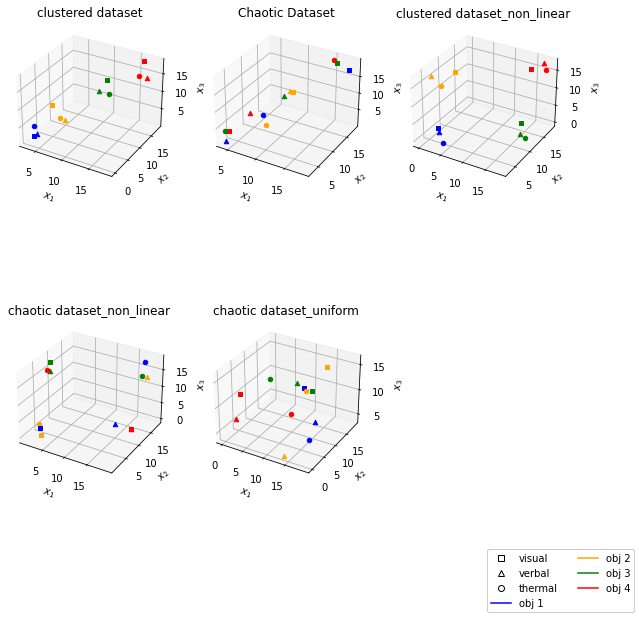

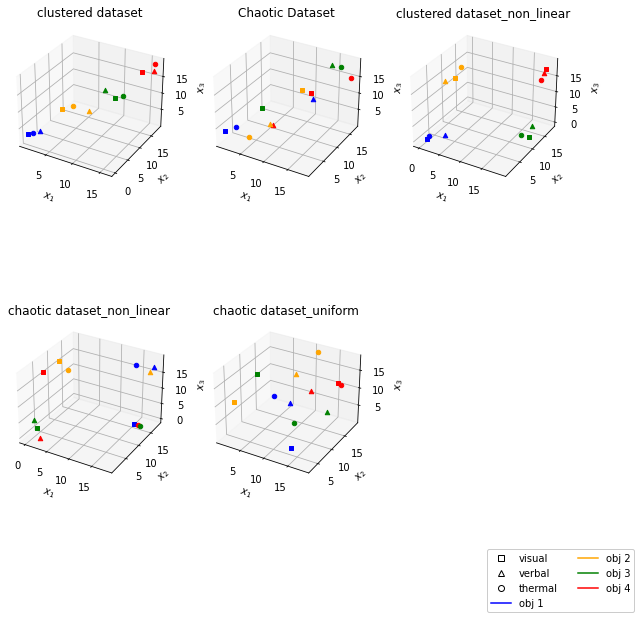

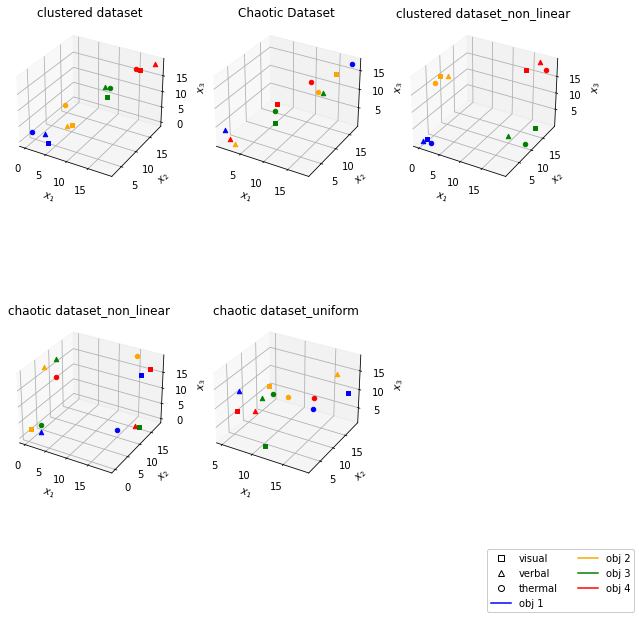

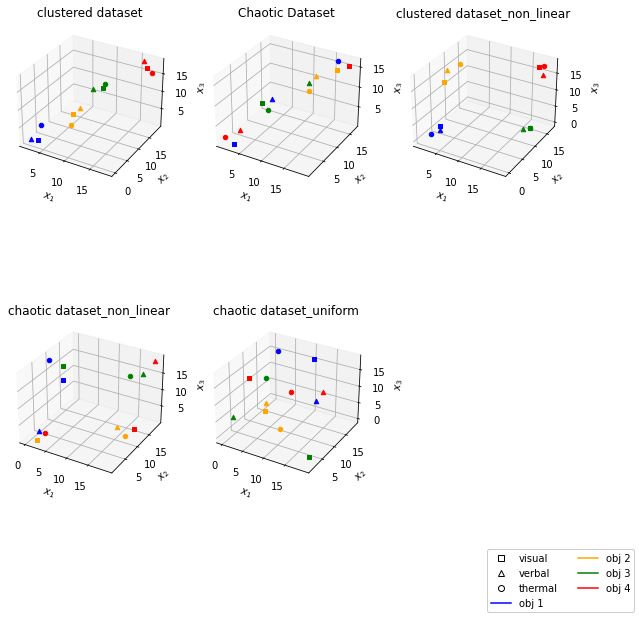

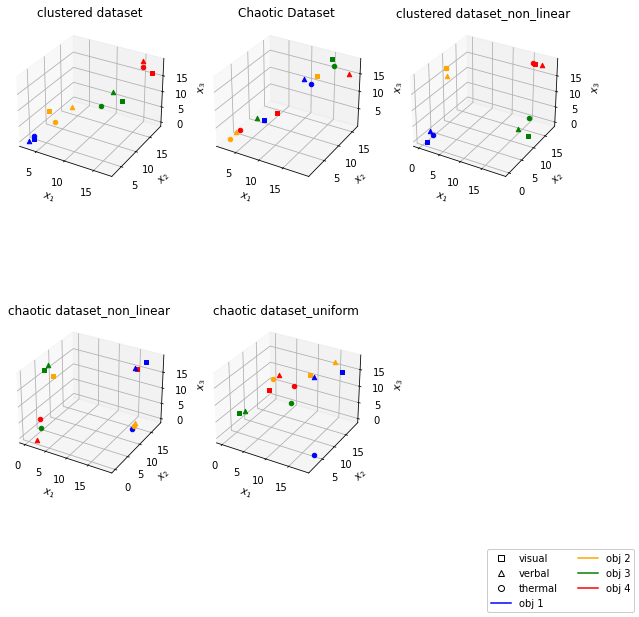

In [60]:
all_runs = runner()
all_runs

In [61]:
for dataset in all_runs.keys():
    logger.info(dataset)
    average_dict = {}
    for term in all_runs[dataset][0].keys():
        average_dict[term] = np.mean([all_runs[dataset][idx][term] for idx in all_runs[dataset].keys()])
    all_runs[dataset]['average'] = average_dict
print(all_runs)        


11/10/2021 00:25:49 - INFO - __main__ - clustered_linear
11/10/2021 00:25:49 - INFO - __main__ - chaotic_linear
11/10/2021 00:25:49 - INFO - __main__ - clustered_non_linear
11/10/2021 00:25:49 - INFO - __main__ - chaotic_non_linear
11/10/2021 00:25:49 - INFO - __main__ - chaotic_uniform


{'clustered_linear': {0: {'loss': 3.11798310702026, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}, 1: {'loss': 2.694743276618606, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}, 2: {'loss': 2.866327774248046, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}, 3: {'loss': 2.860301178755096, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}, 4: {'loss': 3.1190451667993817, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}, 'average': {'loss': 2.9316801006882782, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}}, 'chaotic_linear': {0: {'loss': 3.1731922451601995, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}, 1: {'loss': 3.47922027861711, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}, 2: {'loss': 3.2389996696603216, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}, 3: {'loss': 3.2747376876158003, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}, 4: {'loss': 3.3557828024621985, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}, 'average': {'loss': 3.304386536703126, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}}, 'clustered_non_linear': {0: {'loss': 1.1132567956

In [54]:
for dataset in list(all_runs.keys()):
    print(dataset, ':', all_runs[dataset]['average'])

clustered_linear : {'loss': 2.9316801006882782, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}
chaotic_linear : {'loss': 3.304386536703126, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}
clustered_non_linear : {'loss': 1.8765534747521795, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}
chaotic_non_linear : {'loss': 3.385362285934442, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}
chaotic_uniform : {'loss': 3.515646320086975, 'term1': 0.0, 'term2': 0.0, 'term3': 0.0}


# Speech

## Sort speech tsv and text tsv alphabetically

In [9]:
import pandas as pd

speech_file = '../data/gold_speech_delete.tsv'
speech_dataset_full = pd.read_csv(speech_file, header=0, delimiter='\t', keep_default_na=False)
speech_dataset = speech_dataset_full.reset_index()
print(speech_dataset['item_id'][0:10])
speech_dataset = speech_dataset.sort_values(by=['item_id'])
speech_dataset = speech_dataset.reset_index()
print('=========== after sorting ===========')
print(speech_dataset['item_id'][0:10])


0                            lime_2_4
1    prescription_medicine_bottle_2_1
2                          banana_3_1
3                     eye_glasses_4_3
4                           onion_3_2
5                        food_jar_4_1
6                            lime_3_4
7                    water_bottle_4_3
8                        food_can_4_1
9    prescription_medicine_bottle_3_3
Name: item_id, dtype: object
=========== after sorting ===========
0    allen_wrench_1_1
1    allen_wrench_1_1
2    allen_wrench_1_1
3    allen_wrench_1_1
4    allen_wrench_1_1
5    allen_wrench_1_1
6    allen_wrench_1_1
7    allen_wrench_1_1
8    allen_wrench_1_1
9    allen_wrench_1_1
Name: item_id, dtype: object


## Sort speech.tsv based on text.tsv 

In [10]:
import pandas as pd

csv_file = '../data/gold_text.tsv'
dataset = pd.read_csv(csv_file, header=0, delimiter='\t', keep_default_na=False)
dataset = dataset.reset_index()


speech_file = '../data/gold_speech.tsv'
speech_dataset = pd.read_csv(speech_file, header=0, delimiter='\t', keep_default_na=False)
# speech_dataset = speech_dataset.reset_index()


print('=========== text tsv ===========')
# print(dataset.columns)
# print(dataset['item_id'][0:10])
print(dataset[0:10])
print(type(dataset['item_id']))
print('=========== speech tsv ===========')
# print(speech_dataset.columns)
# print(speech_dataset['item_id'][0:10])
print(speech_dataset[0:10])
speech_dataset = speech_dataset.iloc[list(map(speech_dataset['item_id'].tolist().index, dataset['item_id']))].reset_index()
# speech_dataset = speech_dataset.reset_index()
print('=========== after sorting ===========')
print('len:', len(speech_dataset))
# print(speech_dataset['item_id'][0:10])
print(speech_dataset[0:10])
speech_dataset.to_csv('speech_deleteme2.tsv', sep="\t")





=========== text tsv ===========
   index                          hit_id                         worker_id  \
0      0  306996CF6WIITTJBR6Q44WPDCQ11BX  1717708c7af5468188e808a8d09b5c98   
1      1  306996CF6WIITTJBR6Q44WPDCQ11BX  1717708c7af5468188e808a8d09b5c98   
2      2  306996CF6WIITTJBR6Q44WPDCQ11BX  1717708c7af5468188e808a8d09b5c98   
3      3  306996CF6WIITTJBR6Q44WPDCQ11BX  1717708c7af5468188e808a8d09b5c98   
4      4  306996CF6WIITTJBR6Q44WPDCQ11BX  1717708c7af5468188e808a8d09b5c98   
5      5  306996CF6WIITTJBR6Q44WPDCQ11BX  2f17ff0ad50c48879542d85337051fa4   
6      6  306996CF6WIITTJBR6Q44WPDCQ11BX  2f17ff0ad50c48879542d85337051fa4   
7      7  306996CF6WIITTJBR6Q44WPDCQ11BX  2f17ff0ad50c48879542d85337051fa4   
8      8  306996CF6WIITTJBR6Q44WPDCQ11BX  2f17ff0ad50c48879542d85337051fa4   
9      9  306996CF6WIITTJBR6Q44WPDCQ11BX  2f17ff0ad50c48879542d85337051fa4   

   worktime_s             item_id  \
0         380          potato_3_2   
1         380      can_opener_4_3 

In [3]:
import numpy as np
import pandas as pd

csv_file = '../data/gold_text.tsv'
dataset = pd.read_csv(csv_file, header=0, delimiter='\t', keep_default_na=False)
dataset = dataset.reset_index()


speech_file = '../data/gold_speech.tsv'
speech_dataset = pd.read_csv(speech_file, header=0, delimiter='\t', keep_default_na=False)

# speech_dataset = speech_dataset.iloc[list(map(speech_dataset['item_id'].tolist().index, dataset['item_id']))].reset_index()
# speech_dataset['item_id'].tolist().index('can_opener_3_4')
# map(speech_dataset['item_id'].tolist().index, dataset['item_id'])

new_location = []
item_id_dict = {}
for instance in np.unique(np.array(speech_dataset['item_id'])):
    item_id_dict[instance] = list(np.where(np.array(speech_dataset['item_id'].tolist()) == instance)[0])

for instance in dataset['item_id']:
    new_location.append(item_id_dict[instance].pop())

speech_dataset = speech_dataset.iloc[new_location].reset_index()
speech_dataset.to_csv('speech_deleteme2.tsv', sep="\t")
len(speech_dataset)


16500

In [ ]:
import pandas as pd
import numpy as np


csv_file = '../data/gold_text.tsv'
speech_file = '../data/gold_speech.tsv'

full_dataset = pd.read_csv(csv_file, header=0, delimiter='\t', keep_default_na=False)
dataset = full_dataset.reset_index()


speech_dataset_original = pd.read_csv(speech_file, header=0, delimiter='\t', keep_default_na=False)
# BEGIN sort speech based on full_dataset
item_id_dict = {}
for instance in np.unique(np.array(speech_dataset_original['item_id'])):
    item_id_dict[instance] = list(np.where(np.array(speech_dataset_original['item_id'].tolist()) == instance)[0])
new_location = []
for instance in dataset['item_id']:
    new_location.append(item_id_dict[instance].pop()) # choosing one of the indices from speech tsv for the instance. It doesn't matter because beyond the name of image, nothing is related (paired)
speech_dataset = speech_dataset_original.iloc[new_location].reset_index()
# END sort

a = dataset['item_id']
b = speech_dataset['item_id']
assert(len(a) == len(b))
for i in range(len(a)):
    if a[i] != b[i]:
        print(a[i], b[i])
    assert(a[i] == b[i])
print('everything is fine')


# Analysis

## T-SNE

In [64]:
print(outputs['test']['language'].shape)
embeddings = np.concatenate((outputs['test']['language'], outputs['test']['rgb'], outputs['test']['depth']), axis=0)
print(embeddings.shape)

(4960, 1024)
(14880, 1024)


In [80]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import TSNE

outputs = pickle.load(open('results/4M-mma-simple-SGD-cosine-submodalities-text-anchor-gold-no_neg_sampling-1024/seed-24/outputs.pkl', 'rb'))
embeddings = np.concatenate((outputs['test']['language'], outputs['test']['rgb'], outputs['test']['depth'], outputs['test']['audio']), axis=0)
num_modalities = 4

tsne = TSNE(n_components=2, verbose=1)
projections = tsne.fit_transform(embeddings)
all_projections = np.split(projections, num_modalities, axis=0)

tsne = TSNE(n_components=3, verbose=1)
projections = tsne.fit_transform(embeddings)
all_projections_3D = np.split(projections, num_modalities, axis=0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19840 samples in 0.019s...
[t-SNE] Computed neighbors for 19840 samples in 21.958s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19840
[t-SNE] Computed conditional probabilities for sample 2000 / 19840
[t-SNE] Computed conditional probabilities for sample 3000 / 19840
[t-SNE] Computed conditional probabilities for sample 4000 / 19840
[t-SNE] Computed conditional probabilities for sample 5000 / 19840
[t-SNE] Computed conditional probabilities for sample 6000 / 19840
[t-SNE] Computed conditional probabilities for sample 7000 / 19840
[t-SNE] Computed conditional probabilities for sample 8000 / 19840
[t-SNE] Computed conditional probabilities for sample 9000 / 19840
[t-SNE] Computed conditional probabilities for sample 10000 / 19840
[t-SNE] Computed conditional probabilities for sample 11000 / 19840
[t-SNE] Computed conditional probabilities for sample 12000 / 19840
[t-SNE] Computed conditional probabilities for sa

In [75]:
all_projections[2].shape

(4960, 2)

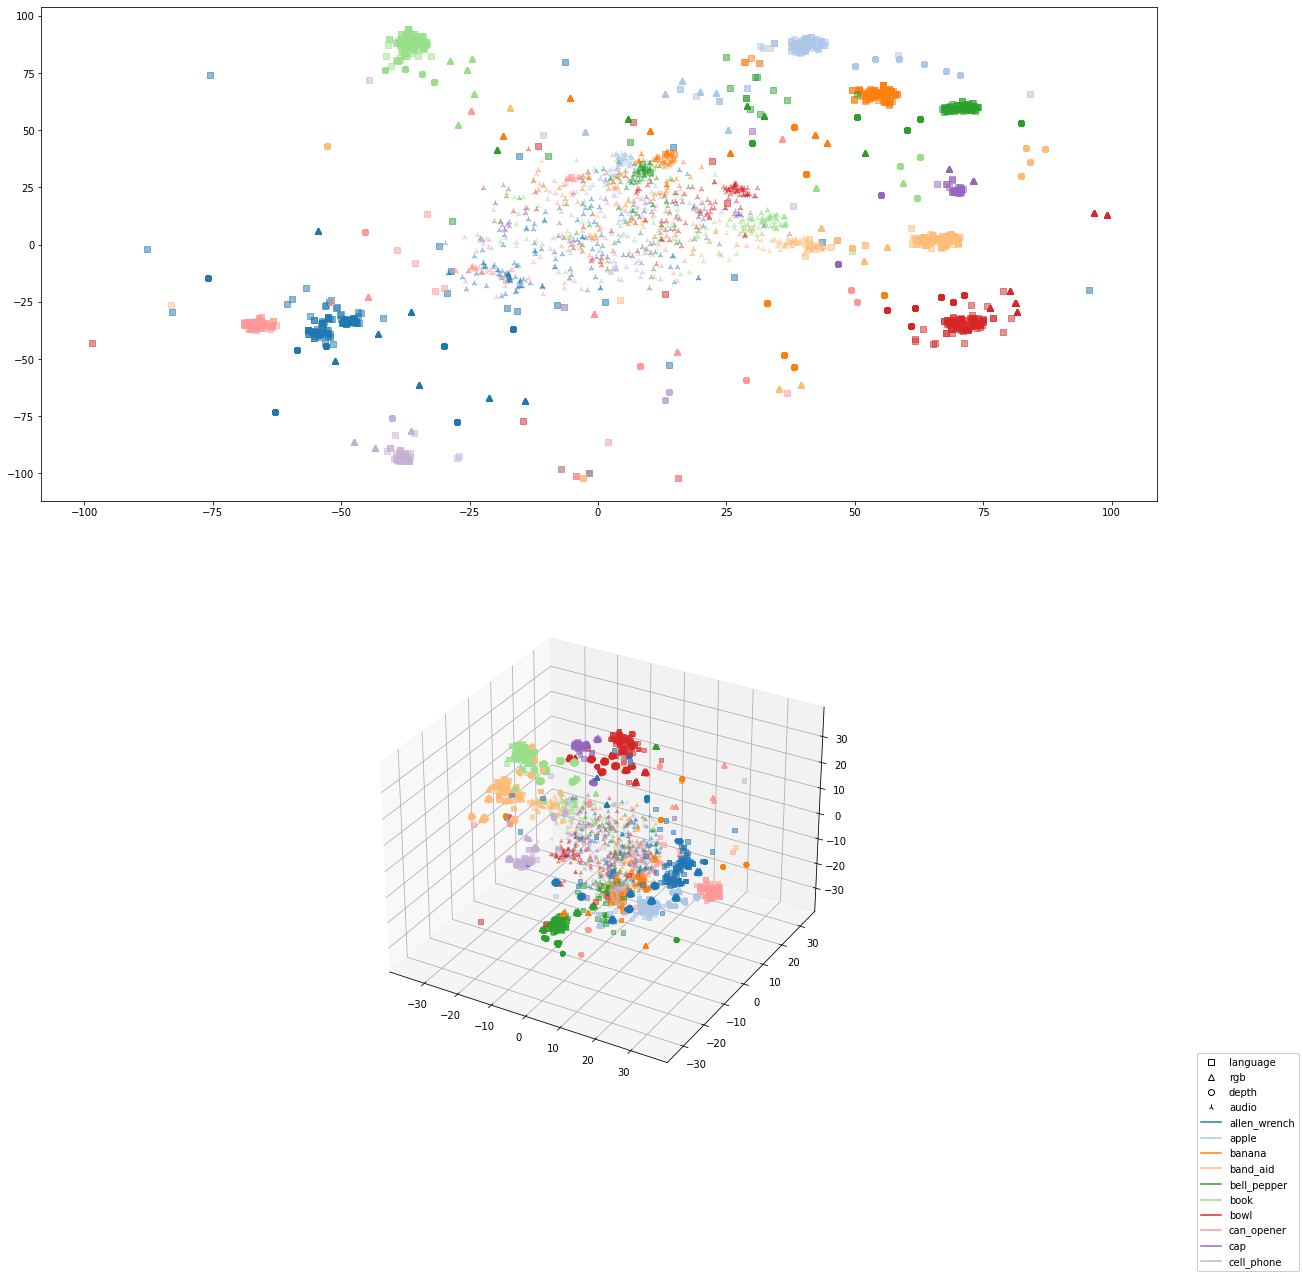

In [135]:
import matplotlib
# Plot those points as a scatter plot and label them based on the pred labels
classes = np.unique(outputs['test']['object_names'])[0:10]
# cmap = plt.get_cmap('nipy_spectral', len(classes))
cmap = cm.get_cmap('tab20')
fig = plt.figure(figsize=(20,20))
markers = ['s', '^', 'o', '2']
ax = fig.add_subplot(2,1,1)
# ax = fig.add_subplot(2,1,1,projection='3d')
for idx in range(len(all_projections)):
    projections = all_projections[idx]
    for lab in classes:
        indices = np.where(np.array(outputs['test']['object_names'])==lab)
        ax.scatter(projections[indices,0], projections[indices,1], c=np.array(cmap(np.where(classes == lab))).reshape(1,4), marker=markers[idx], label = lab ,alpha=0.5)


ax = fig.add_subplot(2,1,2,projection='3d')
for idx in range(len(all_projections_3D)):
    projections = all_projections_3D[idx]
    for lab in classes:
        indices = np.where(np.array(outputs['test']['object_names'])==lab)
        ax.scatter(projections[indices,0], projections[indices,1], projections[indices,2], c=np.array(cmap(np.where(classes == lab))).reshape(1,4), marker=markers[idx], label = lab ,alpha=0.5)


colors = []
for idx in range(len(classes)):
    rgba = cmap(idx)
    c = matplotlib.colors.rgb2hex(rgba)
    colors.append(c)

handles_modal = [plt.plot([], [], markers[i], markerfacecolor='w', markeredgecolor='k')[0] for i in range(len(markers))]
labels_modal = ['language', 'rgb', 'depth', 'audio']
handles_class = [plt.plot([], [], colors[i])[0] for i in range(len(colors))]
labels_class = list(classes)

fig.legend(handles_modal+handles_class, labels_modal+labels_class, loc='lower right', framealpha=1, ncol=1)
# leg = fig.legend(handles=handles_modal, labels=labels_modal, loc='lower left', title="Modality")
# fig.legend(handles=handles_class, labels=labels_class, loc='lower right', title="Categories")
# ax.add_artist(leg)

plt.show()

In [122]:
for i in range(cmap.N):
    
    # rgb2hex accepts rgb or rgba
    print()

#1f77b4
#aec7e8
#ff7f0e
#ffbb78
#2ca02c
#98df8a
#d62728
#ff9896
#9467bd
#c5b0d5
#8c564b
#c49c94
#e377c2
#f7b6d2
#7f7f7f
#c7c7c7
#bcbd22
#dbdb8d
#17becf
#9edae5


In [124]:
colors = []
for idx in range(len(classes)):
    rgba = cmap(idx)
    c = matplotlib.colors.rgb2hex(rgba)
    colors.append(c)
colors

['#1f77b4',
 '#aec7e8',
 '#ff7f0e',
 '#ffbb78',
 '#2ca02c',
 '#98df8a',
 '#d62728',
 '#ff9896',
 '#9467bd',
 '#c5b0d5']